In [1]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import yaml
import torch.nn as nn
import torch.optim as optim
import tqdm

import sys, os
# This is not super pretty, but I think this is the best way to import stuff from ../../../util?
CODE_ROOT = os.path.abspath(os.path.join(os.getcwd(), "..", ".."))
if CODE_ROOT not in sys.path:
    sys.path.insert(1, CODE_ROOT)

from util.spectra_helpers import SpectraCustomHDF5
from first_tranformer_test import Transformer

In [2]:
suite_to_use = "L25n256_realistic_noise_mean_6095_sas"
index_list = [0, 21]
spec_num = 2222

fluxes = []
for i in index_list:
    path_to_file = f"/vera/ptmp/gc/jerbo/training_data/{suite_to_use}/gp{i}_spectra_train.hdf5"
    spec_file = SpectraCustomHDF5(path_to_file)
    wavelengths, flux = spec_file.get_single_spectrum(spec_num)
    fluxes.append(flux)


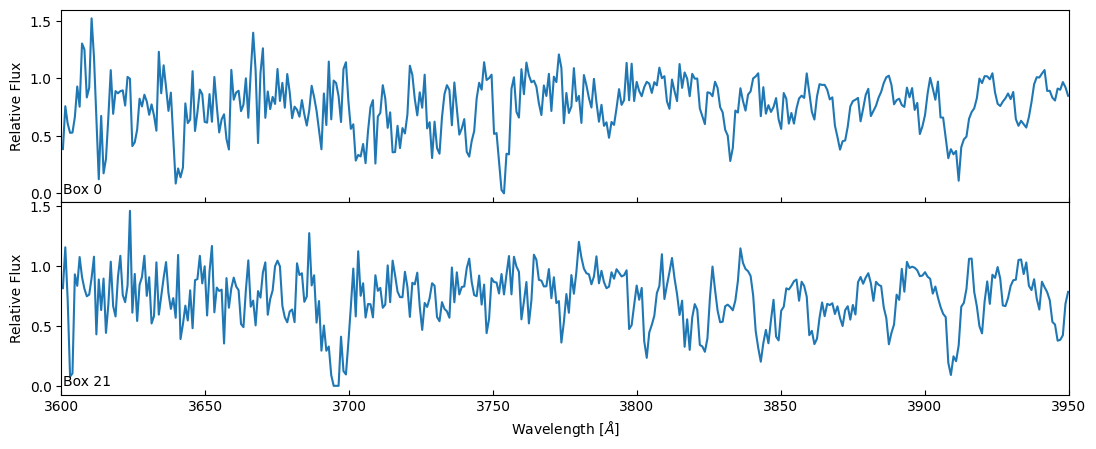

In [3]:
fig, ax = plt.subplots(figsize=(13, 5))

ax.set_xticks([])
ax.set_yticks([])
for spine in ax.spines.values():
    spine.set_visible(False)

gs = gridspec.GridSpec(len(fluxes), 1, hspace=0)
axes = []

for i in range(len(fluxes)):
    ax = fig.add_subplot(gs[i, 0])

    ax.plot(wavelengths, fluxes[i], label="simulated spectra")
    ax.annotate(f"Box {index_list[i]}", (wavelengths[0], min(fluxes[i])))
    # ax.plot(wavelengths, patched_spectra[i], color="black", label="original spectrum")
    ax.set_xlim([3600, 3950])
    ax.set_ylabel("Relative Flux")
    # ax.legend(loc="upper left")
    ax.tick_params(axis='x', direction='in')
    if i == len(fluxes)-1:
        ax.set_xlabel(r"Wavelength [$\AA$]")
    if i < len(fluxes)-1:
        ax.tick_params(labelbottom=False)

    axes.append(ax)

# fig.supxlabel(r"Wavelength [$\AA$]")
# fig.supylabel("Relative Flux")

# plt.savefig("plots/noise_spectra_sim.pdf", format="PDF")
plt.show()

In [ ]:
from astropy.table import Table

lya_cat = Table.read("/vera/u/jerbo/CLIMB-Project/code/development_and_plotting/simulation_notebooks/spectra/data/BOSSLyaDR9_cat.fits")
pmf_list = []
snr_filter = 10

count = 0
for row in lya_cat:
    if row["SNR"] > snr_filter:
        # print(f"({row["PLATE"]}, {row["MJD"]}, {row["FIBERID"]}), ")
        pmf_list.append((row["PLATE"], row["MJD"], row["FIBERID"]))

        count +=1
        #if count > 30:
        #    break
print(count)

5490


In [34]:
import os
import csv
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits

# (plate, mjd, fiber)
"""pmf_list = [
    (4296, 55499, 630), 
    (4217, 55478, 519), 
    (4216, 55477, 166), 
    (4296, 55499, 756), 
    (4365, 55539, 204), 
    (4217, 55478, 933), 
    (4217, 55478, 96), 
    (4218, 55479, 394), 
    (4218, 55479, 696), 
    (4218, 55479, 852), 
    (4219, 55480, 222),
]"""

wavelengths_boss_specs = []
fluxes_boss_specs = []
ivars = []

for plate, mjd, fiber in tqdm.tqdm(pmf_list):
    fiber_str = f"{fiber:04d}"
    filename = f"speclya-{plate}-{mjd}-{fiber_str}.fits"
    file_path = f"/virgotng/mpia/obs/SDSS/BOSSLyaDR9_spectra/{plate}/" + filename

    with fits.open(file_path) as hdul:
        data = hdul[1].data

        loglam   = data["LOGLAM"]
        flux     = data["FLUX"]
        ivar     = data["IVAR"]
        cont     = data["CONT"]
        dla_corr = data["DLA_CORR"]
        mask_comb = data["MASK_COMB"]
        dla_corr = data["DLA_CORR"]
        noise_corr = data["NOISE_CORR"]

    # --- Read RESID ---
    resid_file = "/vera/u/jerbo/CLIMB-Project/code/development_and_plotting/simulation_notebooks/spectra/data/residcorr_v5_4_45.dat"
    resid = []
    resid_lam = []

    with open(resid_file) as rfile:
        reader = csv.reader(rfile, delimiter=" ")
        for i, row in enumerate(reader):
            if i != 0:
                resid.append(float(row[-1]))
                resid_lam.append(float(row[1]))

    resid_lam = np.array(resid_lam)
    resid = np.array(resid)

    i0 = np.where(np.isclose(resid_lam, loglam[0]))[0][0]
    i1 = np.where(np.isclose(resid_lam, loglam[-1]))[0][0] + 1
    resid = resid[i0:i1]

    # Convert to angstroms
    wavelength = 10**loglam

    # ---------------------------------------------------
    # SDSS-recommended pixel mask
    # ---------------------------------------------------
    good_pixel = (
        (mask_comb == 0) &     # SDSS quality mask
        (ivar > 0)
    )

    # Initialize F with NaNs
    F = np.full_like(flux, np.nan)
    SIGMA_F = np.full_like(flux, np.nan)

    # Compute transmission ONLY for good pixels
    F[good_pixel] = (flux[good_pixel] * dla_corr[good_pixel] / ((cont[good_pixel] * resid[good_pixel])))
    # F = (flux * dla_corr / ((cont * resid)))

    SIGMA_F[good_pixel] = np.sqrt(ivar[good_pixel] * resid[good_pixel]**2 * noise_corr[good_pixel]**2 * cont[good_pixel]**2 / dla_corr[good_pixel]**2)

    # --- Select Lyα forest region ---
    forest_mask = (
        (wavelength >= 3600.0) &
        (wavelength <= 3950.0)
    )

    wave_sel = wavelength[forest_mask]
    F_sel    = F[forest_mask]
    Sigma_F_sel = SIGMA_F[forest_mask]

    # print(len(F_sel), len(wave_sel))

    if np.any(np.isnan(F_sel)) or  (not np.all(np.isfinite(F_sel))):
        # print(F_sel)
        continue   # skip this spectrum
    
    ivars.append(Sigma_F_sel)
    wavelengths_boss_specs.append(wave_sel)
    fluxes_boss_specs.append(F_sel)


  0%|          | 0/5490 [00:00<?, ?it/s]

/tmp/ipykernel_31218/3140951641.py:78: RuntimeWarning: divide by zero encountered in divide
  F[good_pixel] = (flux[good_pixel] * dla_corr[good_pixel] / ((cont[good_pixel] * resid[good_pixel])))
100%|██████████| 5490/5490 [02:56<00:00, 31.03it/s]


In [19]:
print(len(fluxes_boss_specs)) # 2293

8142


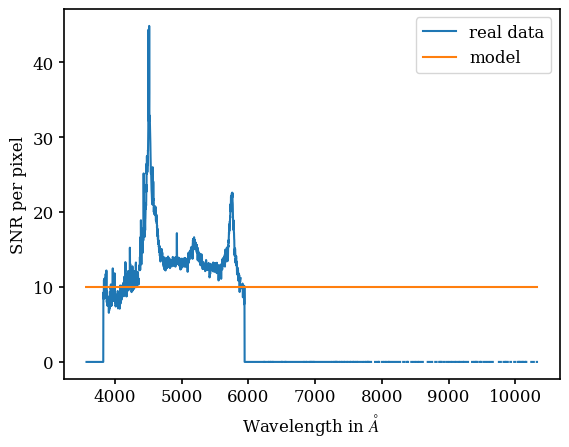

In [20]:
plt.plot(wavelength, SIGMA_F, label="real data")
plt.plot(wavelength, [10]*len(wavelength), label="model")
plt.xlabel(r"Wavelength in $\AA$")
plt.ylabel("SNR per pixel")
plt.legend()
plt.savefig("plots/noise_spectra_SDSS_SNR.pdf", format="PDF")

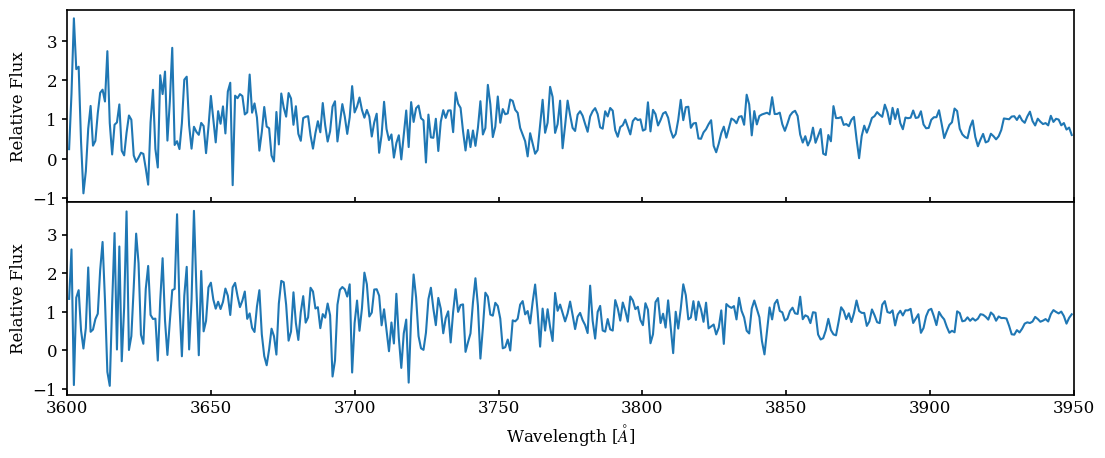

In [21]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

fluxes_boss_specs_plot = fluxes_boss_specs[-2:]
wavelengths_boss_specs_plot = wavelengths_boss_specs[-2:]

fig, ax = plt.subplots(figsize=(13, 5))

ax.set_xticks([])
ax.set_yticks([])
for spine in ax.spines.values():
    spine.set_visible(False)

gs = gridspec.GridSpec(len(fluxes_boss_specs_plot), 1, hspace=0)
axes = []

for i in range(len(fluxes_boss_specs_plot)):
    ax = fig.add_subplot(gs[i, 0])
    # print(fluxes_boss_specs_plot[i])
    ax.plot(wavelengths_boss_specs_plot[i], fluxes_boss_specs_plot[i], label="simulated spectra")
    # ax.annotate(f"Box {index_list[i]}", (wavelengths_boss_specs_plot[0], min(fluxes_boss_specs_plot[i])))
    # ax.plot(wavelengths, patched_spectra[i], color="black", label="original spectrum")
    # ax.set_xlim([left_cut, right_cut])
    ax.set_ylabel("Relative Flux")
    ax.set_xlim([3600, 3950])
    # ax.legend(loc="upper left")
    ax.tick_params(axis='x', direction='in')
    if i == len(fluxes_boss_specs_plot)-1:
        ax.set_xlabel(r"Wavelength [$\AA$]")
    if i < len(fluxes_boss_specs_plot)-1:
        ax.tick_params(labelbottom=False)

    axes.append(ax)

# fig.supxlabel(r"Wavelength [$\AA$]")
# fig.supylabel("Relative Flux")

plt.savefig("plots/noise_spectra_SDSS.pdf", format="PDF")
plt.show()

In [35]:
import torch

tensor_specs = []
ivar_snrs = []
for i, spec in enumerate(fluxes_boss_specs):
    if len(spec) == 402:
        tensor_specs.append(np.append(spec, spec[-1]))
        ivar_snrs.append(np.append(ivars[i], ivars[i][-1]))

t = torch.Tensor(np.array(tensor_specs))
snrs_pp = np.array(ivar_snrs)

print(t.shape)
print(snrs_pp.shape)

torch.Size([1957, 403])
(1957, 403)


(403,)


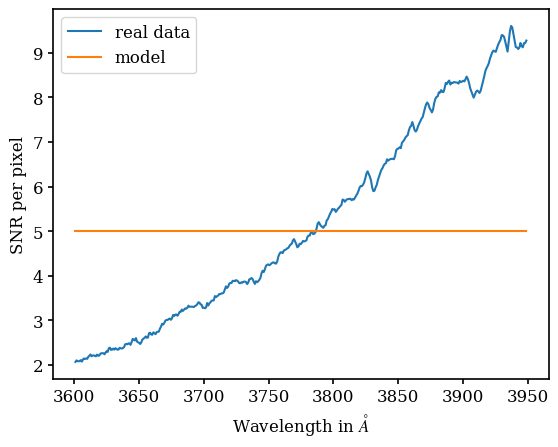

In [32]:
ivars_mean = np.mean(snrs_pp, axis=0)#np.mean(snrs_pp, axis=0)
print(ivars_mean.shape)

np.save("snr_SDSS_spectra_mean_5.npy", ivars_mean)

plt.plot(wavelengths_boss_specs[0], ivars_mean[:-1], label="real data")
plt.plot(wavelengths_boss_specs[0], [5]*len(wavelengths_boss_specs[0]), label="model")
plt.xlabel(r"Wavelength in $\AA$")
plt.ylabel("SNR per pixel")
plt.legend()
plt.savefig("plots/noise_spectra_SDSS_SNR.pdf", format="PDF")

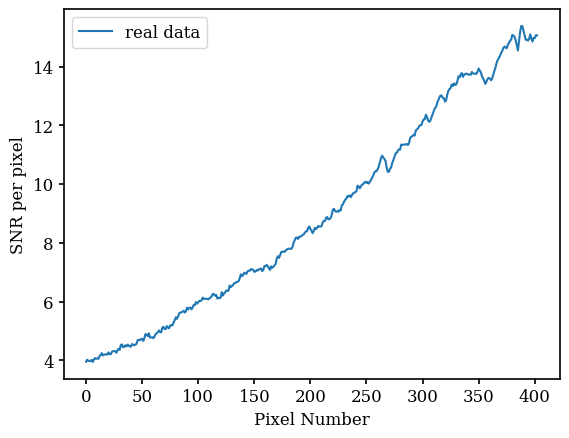

In [24]:
import numpy as np
import matplotlib.pyplot as plt
snr_loaded = np.load("/vera/u/jerbo/CLIMB-Project/code/data_generation_pipeline/snr_SDSS_spectra_mean.npy")
plt.plot([i for i in range(len(snr_loaded))], snr_loaded, label="real data")
# plt.plot(wavelengths_boss_specs[0], [10]*len(wavelengths_boss_specs[0]), label="model")
plt.xlabel("Pixel Number")
plt.ylabel("SNR per pixel")
plt.legend()
plt.savefig("plots/noise_spectra_SDSS_SNR.pdf", format="PDF")


In [36]:
model_name = "opt_model_realistic_noise_mean"  # set this variable to the model to visualize

weights_path = f"model_states/train_{model_name}/finished_model_weights.pt"
train_loss_path = f"loss_files/{model_name}_train_eval_loss.csv"

with open(f"/vera/u/jerbo/CLIMB-Project/code/Machine_Learning/Transformer_testing/log_files/{model_name}_config.yaml") as f:
    params = yaml.safe_load(f)

# suite_to_use = params['suite_to_use']
suite_of_spectra = params['suite_of_spectra']
batch_size = params['batch_size']
n_epochs = params['n_epochs']
learning_rate = params['learning_rate']

d_model = params['model']['d_model']
num_heads = params['model']['num_heads']
num_layers = params['model']['num_layers']
d_ff = params['model']['d_ff']
dropout = params['model']['dropout']

len_spectra = t.shape[1]
len_output = 4

device = torch.device("cpu")

model = Transformer(len_spectra, len_output, d_model, num_heads, num_layers, d_ff, dropout)

state_dict = torch.load(weights_path, map_location=device)
model.load_state_dict(state_dict)

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

print(model)
print("Number of network parameters:", np.sum([np.prod(theta.shape) for theta in model.parameters()]))

Transformer(
  (encoder_embedding): SpectraTokenEmbedding(
    (proj): Linear(in_features=1, out_features=192, bias=True)
  )
  (positional_encoding): PositionalEncoding()
  (encoding_layers): ModuleList(
    (0-3): 4 x EncoderLayer(
      (self_attn): MultiHeadAttention(
        (W_q): Linear(in_features=192, out_features=192, bias=True)
        (W_k): Linear(in_features=192, out_features=192, bias=True)
        (W_v): Linear(in_features=192, out_features=192, bias=True)
        (W_o): Linear(in_features=192, out_features=192, bias=True)
      )
      (feed_forward): PositionWiseFeedForward(
        (fc1): Linear(in_features=192, out_features=1152, bias=True)
        (fc2): Linear(in_features=1152, out_features=192, bias=True)
        (relu): ReLU()
      )
      (norm1): LayerNorm((192,), eps=1e-05, elementwise_affine=True)
      (norm2): LayerNorm((192,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.011, inplace=False)
    )
  )
  (fc): Linear(in_features=192, ou

In [37]:
def eval_model(model, X, device):
    model.eval()

    with torch.no_grad():
        X = X.to(device)

        y_pred = model(X)

    return y_pred

y_pred = eval_model(model, t, device)

In [38]:
y_mean, y_std = torch.Tensor([0.2955, 0.0495, 0.7045, 0.6998]), torch.Tensor([0.1028, 0.0301, 0.1028, 0.0866])

In [39]:
y_pred  = y_pred*y_std + y_mean
y_pred = y_pred.numpy()

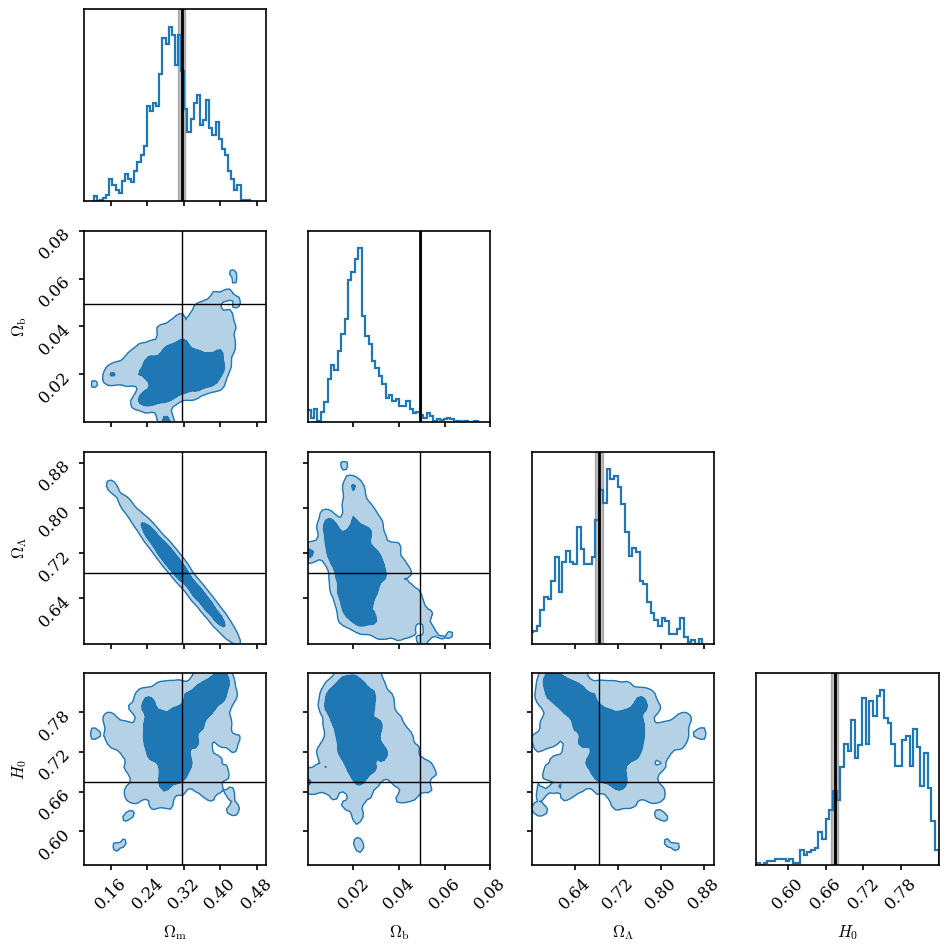

In [ ]:
import corner
import numpy as np
import matplotlib.pyplot as plt

# Your inferred samples
samples = y_pred  # shape (N, 4)

labels = [
    r"$\Omega_{\mathrm{m}}$",
    r"$\Omega_{\mathrm{b}}$",
    r"$\Omega_{\Lambda}$",
    r"$H_0$"
]

# Planck values
planck = np.array([0.315, 0.0493, 0.685, 0.674])
planck_err = np.array([0.007, 2.2e-4, 0.007, 0.005])
#planck = np.array([0.3089, 0.0486, 0.6911, 0.6774]) 

# Global matplotlib style tweaks (very Planck-y)
plt.rcParams.update({
    "font.size": 12,
    "font.family": "serif",
    "mathtext.fontset": "cm",
    "axes.linewidth": 1.2,
    "xtick.major.width": 1.2,
    "ytick.major.width": 1.2
})

fig = corner.corner(
    samples,
    labels=labels,
    bins=50,
    smooth=1.2,
    color="#1f77b4",
    plot_datapoints=False,
    fill_contours=True,
    levels=(0.68, 0.95),
    contour_kwargs={"linewidths": [1, 1]},
    hist_kwargs={"density": True, "linewidth": 1.6},
)

axes = np.array(fig.axes).reshape((4, 4))

# Overlay Planck constraints
for i in range(4):
    # Diagonal: 1D constraints
    ax = axes[i, i]
    ax.axvline(planck[i], color="black", lw=2)
    ax.axvspan(
        planck[i] - planck_err[i],
        planck[i] + planck_err[i],
        color="black",
        alpha=0.25
    )

    # Off-diagonal: Planck crosshairs
    for j in range(i):
        ax = axes[i, j]
        ax.axvline(planck[j], color="black", lw=1)
        ax.axhline(planck[i], color="black", lw=1)

axes = np.array(fig.axes).reshape((4, 4))

# Define tighter limits (tune as needed)
omega_m_lim = (0.1, 0.5)
omega_b_lim = (0.0, 0.08)
omega_L_lim = (0.56, 0.9)

# Diagonal panels
axes[0, 0].set_xlim(omega_m_lim)
axes[1, 1].set_xlim(omega_b_lim)
axes[2, 2].set_xlim(omega_L_lim)

# Off-diagonal panels involving Ωm
for i in range(1, 4):
    axes[i, 0].set_xlim(omega_m_lim)
    axes[0, i].set_ylim(omega_m_lim)

# Off-diagonal panels involving ΩΛ
for i in range(4):
    if i != 2:
        axes[2, i].set_ylim(omega_L_lim)
        axes[i, 2].set_xlim(omega_L_lim)

# Off-diagonal panels involving Ωb
for i in range(4):
    if i != 1:
        axes[1, i].set_ylim(omega_b_lim)
        axes[i, 1].set_xlim(omega_b_lim)



plt.tight_layout()
plt.savefig(f"plots/{model_name}_SDSS_spectra_snr{snr_filter}.pdf", format="PDF")
plt.show()


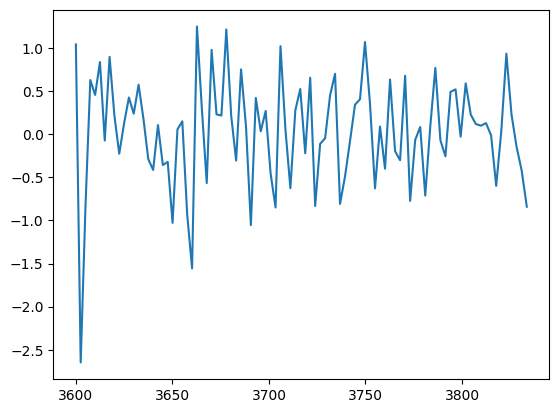

In [ ]:
import os
import csv
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits

file_path = f"/virgotng/mpia/obs/SDSS/Delta_LYA/delta-432.fits"

with fits.open(file_path) as hdul:
    data = hdul[1].data

    loglam   = data["LOGLAM"]
    flux     = data["DELTA"]
    weight     = data["WEIGHT"]
    cont     = data["CONT"]

# Convert to angstroms
wavelength = 10**loglam

# --- Select Lyα forest region ---
forest_mask = (
    (wavelength >= 3550.0) &
    (wavelength <= 3950.0)
)

wave_sel = wavelength# [forest_mask]
F_sel    = flux * cont# [forest_mask]  * cont[forest_mask]

plt.plot(wave_sel, F_sel)
plt.show()
